In [2]:
# =========================
# IMPORTING LIBRARIES
# =========================
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [7]:
# =========================
# LOADING THE DATASET
# =========================
df = pd.read_csv('https://raw.githubusercontent.com/ayushbora2003/Property_Price_Prediction/main/data/house_prices.csv')

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


In [8]:
# =========================
# FEATURE ENGINEERING
# =========================

df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['people_per_household'] = df['population'] / df['households']

# Replace infinities
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values only for numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


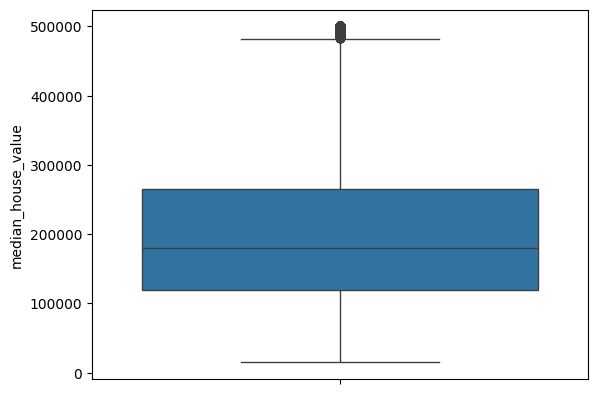

In [9]:
sns.boxplot(df['median_house_value'])
plt.show()


In [10]:
# =========================
# EXPLORATORY DATA ANALYSIS
# =========================

print("\nDataset Info:")
df.info()

print("\nSummary Statistics:")
print(df.describe())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   longitude             20640 non-null  float64
 1   latitude              20640 non-null  float64
 2   housing_median_age    20640 non-null  int64  
 3   total_rooms           20640 non-null  int64  
 4   total_bedrooms        20640 non-null  float64
 5   population            20640 non-null  int64  
 6   households            20640 non-null  int64  
 7   median_income         20640 non-null  float64
 8   median_house_value    20640 non-null  int64  
 9   ocean_proximity       20640 non-null  object 
 10  rooms_per_household   20640 non-null  float64
 11  bedrooms_per_room     20640 non-null  float64
 12  people_per_household  20640 non-null  float64
dtypes: float64(7), int64(5), object(1)
memory usage: 2.0+ MB

Summary Statistics:
          longitude      lat

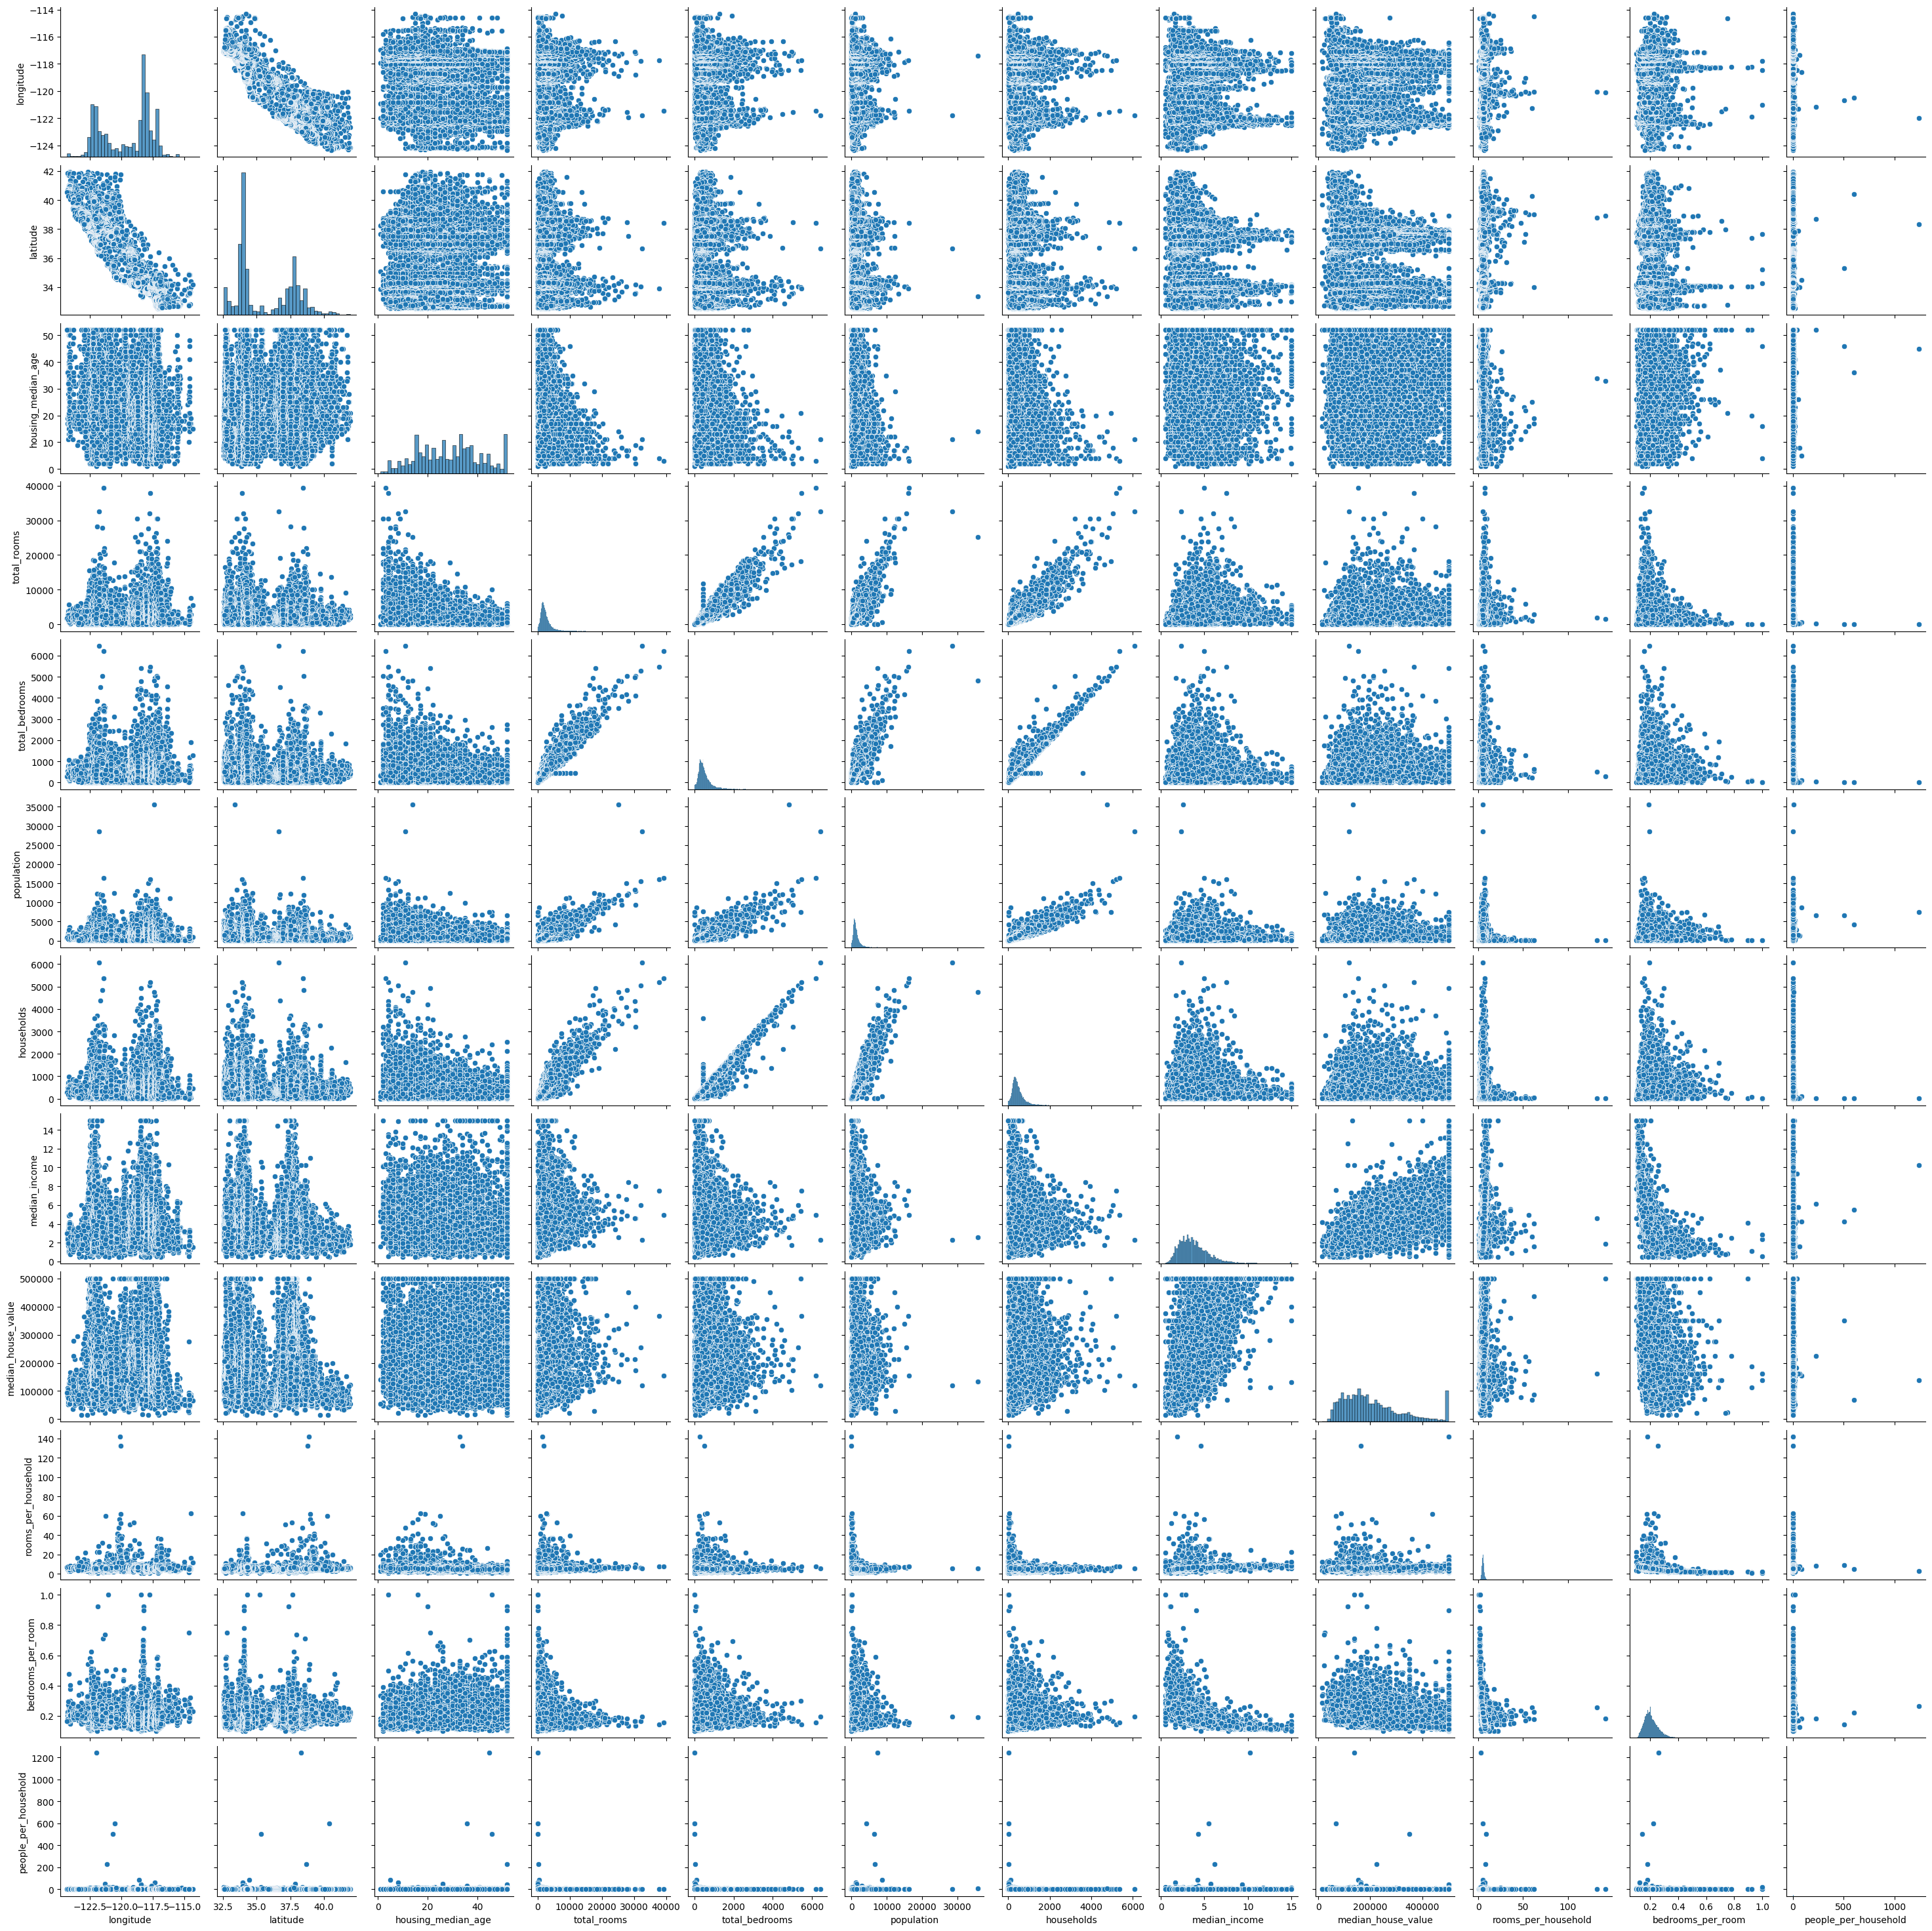

In [68]:
# Pairplot
sns.pairplot(df)
plt.show()


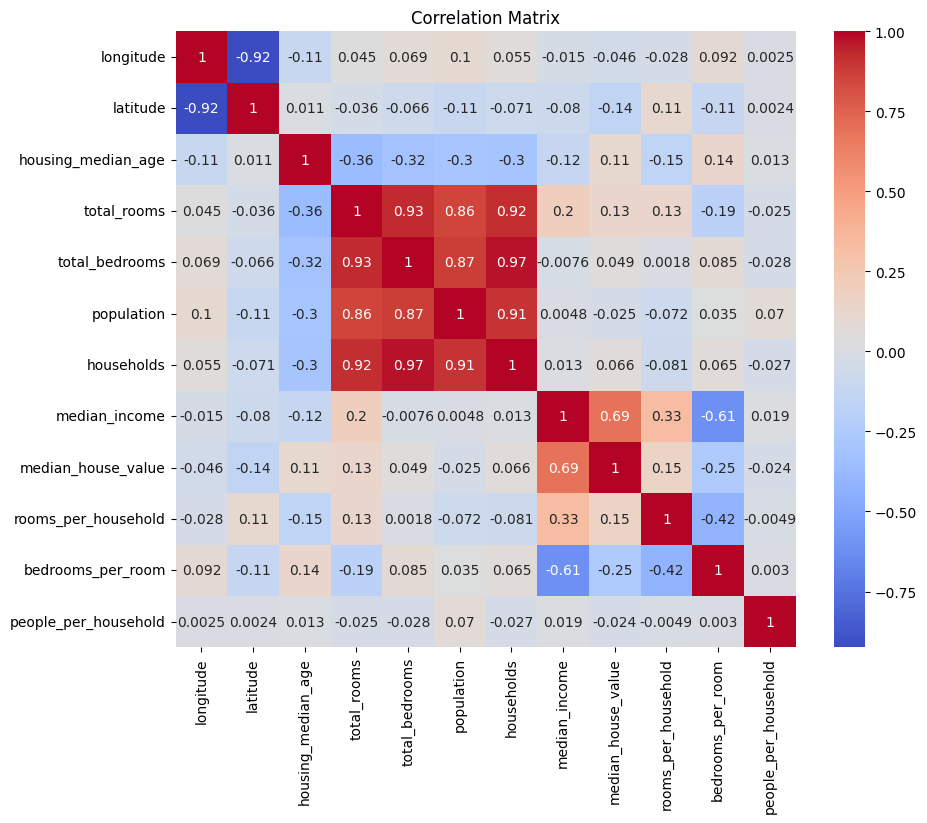

In [11]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

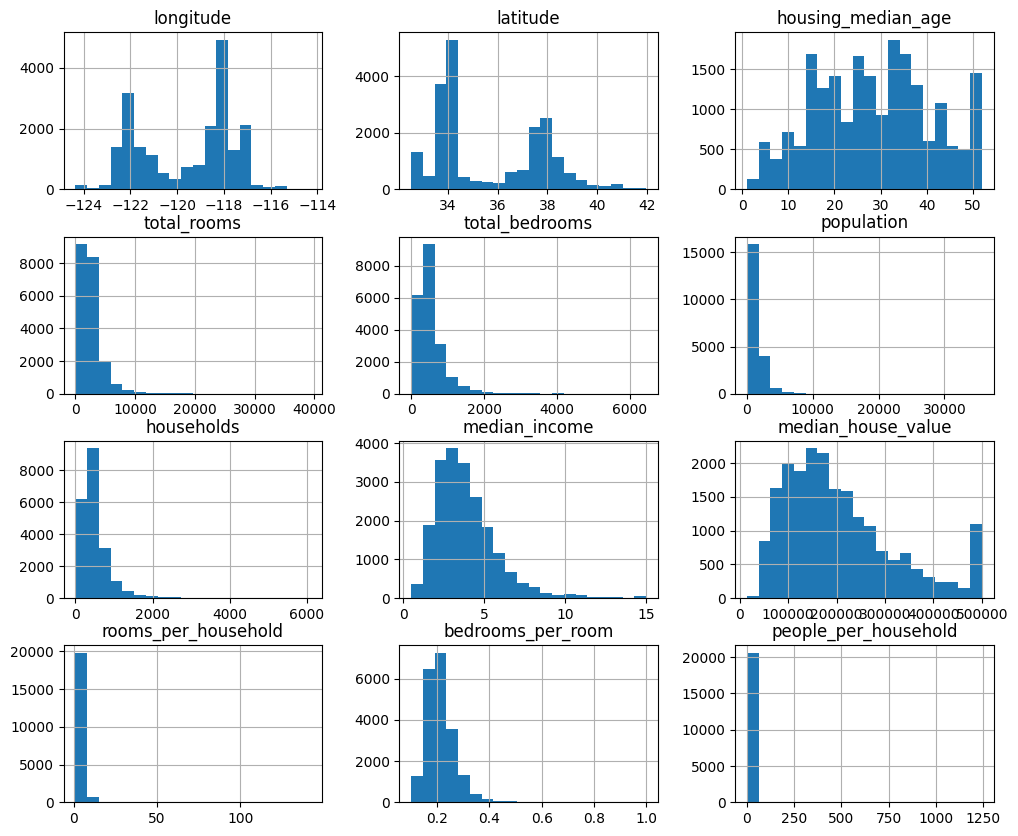

In [12]:
# Histograms
df.hist(figsize=(12,10), bins=20)
plt.show()

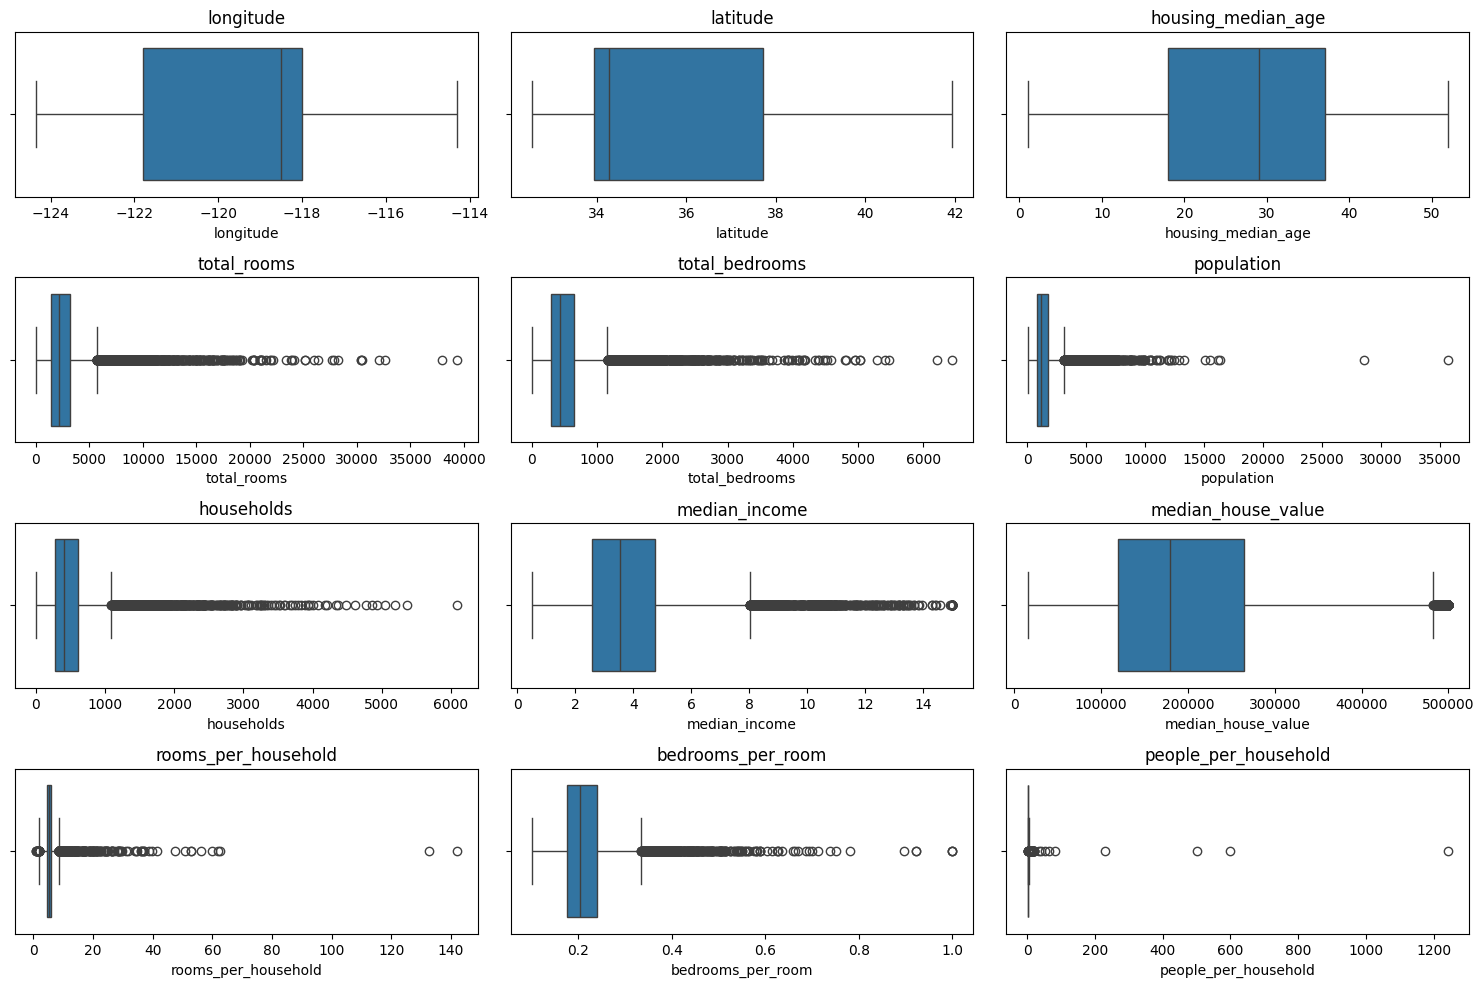

In [13]:
# Boxplots

num_cols = len(numeric_cols)
rows = (num_cols // 3) + 1
plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_cols):
    plt.subplot(rows, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()




In [14]:
# =========================
#  SIMPLE LINEAR REGRESSION
# =========================

X = df[['median_income']]
Y = df['median_house_value']

In [15]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [16]:
# Train model
simple_model = LinearRegression()
simple_model.fit(X_train, Y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [17]:
# Predictions
Y_pred = simple_model.predict(X_test)

In [18]:
# Evaluation
print("\nSIMPLE LINEAR REGRESSION RESULTS")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"R² Score: {r2_score(Y_test, Y_pred)}")


SIMPLE LINEAR REGRESSION RESULTS
Mean Squared Error: 7091157771.76555
R² Score: 0.45885918903846656


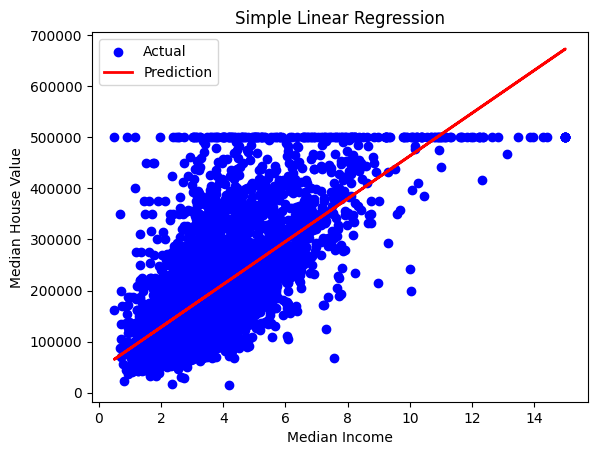

In [19]:
# Plot regression line
plt.scatter(X_test, Y_test, color='blue', label='Actual')
plt.plot(X_test, Y_pred, color='red', linewidth=2, label='Prediction')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.title('Simple Linear Regression')
plt.legend()
plt.show()

In [20]:
# User input prediction
median_income = float(input("\nEnter median income: "))
predicted_price = simple_model.predict([[median_income]])
print(f"Predicted House Price: ₹{predicted_price[0]:.2f}")


Enter median income:  4.3


Predicted House Price: ₹224775.28


C:\Users\ayush\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [21]:
# =========================
# 📌 MULTIPLE LINEAR REGRESSION
# =========================

X_multi = df[['longitude','latitude','housing_median_age','total_rooms',
              'total_bedrooms','population','households','median_income',
              'ocean_proximity',
              'rooms_per_household', 'bedrooms_per_room', 'people_per_household']]


Y_multi = df['median_house_value']

In [22]:
# Detect numeric & categorical columns
numeric_features = X_multi.select_dtypes(include=['number']).columns
categorical_features = X_multi.select_dtypes(include=['object']).columns

In [23]:
# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [24]:
# Train-test split
X_train_multi, X_test_multi, Y_train_multi, Y_test_multi = train_test_split(
    X_multi, Y_multi, test_size=0.2, random_state=42
)



In [25]:
# Build full pipeline
multi_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
multi_model.fit(X_train_multi, Y_train_multi)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
# Predictions
Y_pred_multi = multi_model.predict(X_test_multi)

In [27]:
# Evaluation
print("\n MULTIPLE LINEAR REGRESSION RESULTS")
mse = mean_squared_error(Y_test_multi, Y_pred_multi)
r2 = r2_score(Y_test_multi, Y_pred_multi)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")



 MULTIPLE LINEAR REGRESSION RESULTS
Mean Squared Error: 4778516268.237818
Root Mean Squared Error (RMSE): 69126.81294720463
R² Score: 0.6353416110859891


<Axes: xlabel='median_house_value', ylabel='Count'>

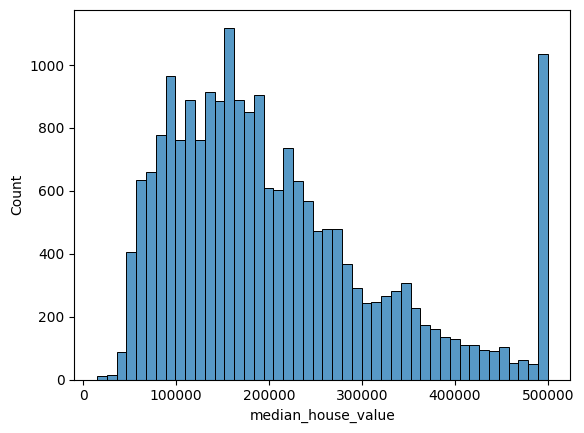

In [88]:
sns.histplot(df['median_house_value'])



<Axes: ylabel='median_house_value'>

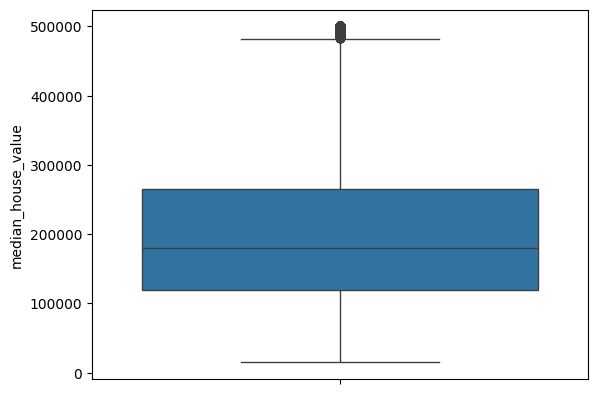

In [89]:
sns.boxplot(df['median_house_value'])


<Axes: xlabel='median_income', ylabel='median_house_value'>

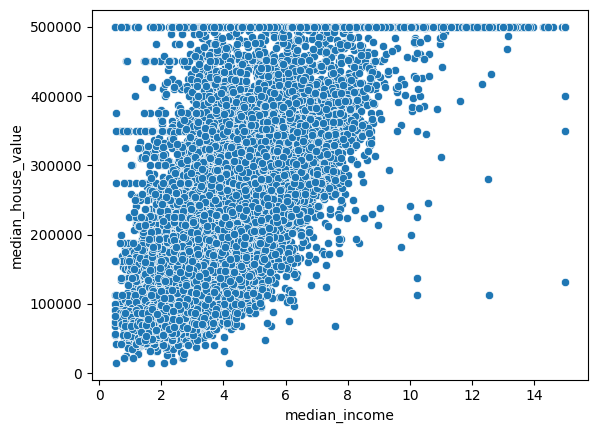

In [90]:
sns.scatterplot(x='median_income', y='median_house_value', data=df)